In [1]:
import numpy as np 
import pandas as pd
import scipy.stats as ss
import statsmodels.stats.stattools as stats
import statsmodels.formula.api as sm
import statsmodels.api as sma
import statsmodels.tsa.api as smt
import statsmodels as stat
import linearmodels as lm
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

import datetime
import holidays 
from workalendar.europe import NetherlandsWithSchoolHolidays as NL

import hvplot.pandas 
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

# 1. Importing data and cleaning

In [2]:
df = pd.read_csv(r'C:\Users\Mathis Mourey\Downloads\cleandata.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,9,11,12,15,18,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.columns

Index(['ï»¿Code sharing', 'Slot gecoÃ¶rdineerd', 'Vertragingscode(s)',
       'Via luchthaven(s)', 'Vluchtnummer', 'Vliegtuigregistratie',
       'Vliegtuigtype', 'Luchthaven', 'Verkeerstype', 'Startbaan',
       'Geplande datum/tijd', 'Actuele datum/tijd', 'Vluchtcode', 'Pax',
       'Pay pax', 'Status', 'Systeemstatus', 'Afhandelaar', 'Debiteur',
       'Gemigreerde data', 'Geautoriseerd', 'BookedPayPax', 'MTOW (kg)',
       'Maatschappij', 'Max. # zitplaatsen'],
      dtype='object')

In [136]:
# get datetime dates and redefine a new dataframe with variable of interest.
#ts = pd.to_datetime(df['Geplande datum/tijd'], errors='coerce')
red_df = df[['Pax', 'Pay pax', 'BookedPayPax', 'Maatschappij']]
red_df['timestamp'] = ts
red_df

<ipython-input-136-8ed26f539bb5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_df['timestamp'] = ts


Pax  Pay pax BookedPayPax              Maatschappij  \
0       NaN      NaN          NaN                       NaN   
1       NaN      NaN          NaN                       NaN   
2       NaN      NaN          NaN                       NaN   
3       NaN      NaN          NaN                       NaN   
4       NaN      NaN          NaN                       NaN   
...     ...      ...          ...                       ...   
857156  NaN      NaN          NaN                       NaN   
857157  NaN      NaN          4.0                       NaN   
857158  NaN      NaN          NaN                       NaN   
857159  NaN      NaN          2.0  Air Hamburg Private Jets   
857160  NaN      NaN          NaN                       NaN   

                 timestamp  
0      2021-08-31 08:50:00  
1      2021-08-31 07:00:00  
2      2021-08-31 07:14:00  
3      2021-08-31 06:15:00  
4      2021-08-31 07:10:00  
...                    ...  
857156 2021-03-24 10:10:00  
857157 2021-06-11 05:30:00  
857158 2021-03-18 20:00:00  
857159 2020-05-28 13:36:00  
857160 2021-08-31 09:00:00  

[857161 rows x 5 columns]

In [137]:
red_df['BookedPayPax'] = red_df['BookedPayPax'].replace('Nee', None)
red_df['BookedPayPax'] = red_df['BookedPayPax'].replace('Ja', None)
red_df['BookedPayPax']= [int(i) if pd.isnull(i)==False else None for i in red_df['BookedPayPax']]

<ipython-input-137-b857e73a1d8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_df['BookedPayPax'] = red_df['BookedPayPax'].replace('Nee', None)
<ipython-input-137-b857e73a1d8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_df['BookedPayPax'] = red_df['BookedPayPax'].replace('Ja', None)
<ipython-input-137-b857e73a1d8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [138]:
red_df.to_csv('cleaned_data_reduced.csv')

<AxesSubplot:xlabel='timestamp'>

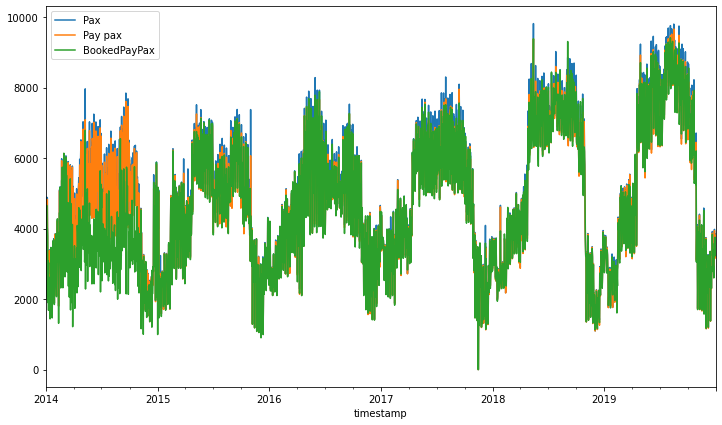

In [139]:
# Visualizing the raw data
data = (red_df.set_index('timestamp')
        .resample('D').sum()
        ['2014':'2019'])
data.plot(figsize=(12,7))

<AxesSubplot:xlabel='timestamp'>

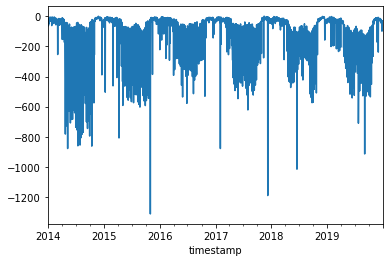

In [140]:
(data['Pay pax'] - data['Pax']).plot()

### Features creation

1. Create features for months, days, weeks, etc.

In [94]:
calendar = NL(region='south', carnival_instead_of_spring=True)
all_holidays = []
for i in list(data.index.year.unique())[2:]:
    for j in calendar.holidays(i):
        all_holidays.append(j[0])

In [99]:
# Function to find the number of the week in a month
def WeekNumber(date_value):
    week = date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1
    return date_value.isocalendar()[1] if week < 0 else week

# Rename for use in the regression
data = data.rename(columns={"Pay pax": "Pay_pax"})

data['Holidays'] = [1 if i in all_holidays else 0 for i in data.index]

data['Days_of_year'] = data.index.dayofyear
data['Month'] = data.index.month
data['Week'] = data.index.week
data['Week_Month'] = [WeekNumber(i) for i in data.index]
data['Day_Number'] = data.index.day

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['Day_Name'] = data.index.day_name()

data['Time'] = [i for i in range(len(data))]
data['Time2'] = data['Time']**2

data['Pay_pax_L1'] = data['Pay_pax'].shift(-1)
data = data.fillna(0)

# One data point is negative (to be retreated)
data[data['Pay_pax'] < 1] = 1
data

<ipython-input-99-1462dec7c9ad>:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['Week'] = data.index.week


Pay_pax  BookedPayPax  Days_of_year  Month  Week  Week_Month  \
timestamp                                                                  
2014-01-01   3167.0        1989.0             1      1     1           1   
2014-01-02   3361.0        2205.0             2      1     1           1   
2014-01-03   4828.0        4656.0             3      1     1           1   
2014-01-04   3023.0        2425.0             4      1     1           1   
2014-01-05   4821.0        4005.0             5      1     1           1   
...             ...           ...           ...    ...   ...         ...   
2019-12-27   3937.0        3581.0           361     12    52           5   
2019-12-28   3235.0        3215.0           362     12    52           5   
2019-12-29   3810.0        3752.0           363     12    52           5   
2019-12-30   3582.0        3479.0           364     12     1           1   
2019-12-31   3165.0        3469.0           365     12     1           1   

            Day_Number   Day_Name  Time    Time2  Pay_pax_L1  Holidays  
timestamp                                                               
2014-01-01           1  Wednesday     0        0      3361.0         0  
2014-01-02           2   Thursday     1        1      4828.0         0  
2014-01-03           3     Friday     2        4      3023.0         0  
2014-01-04           4   Saturday     3        9      4821.0         0  
2014-01-05           5     Sunday     4       16      3757.0         0  
...                ...        ...   ...      ...         ...       ...  
2019-12-27          27     Friday  2186  4778596      3235.0         1  
2019-12-28          28   Saturday  2187  4782969      3810.0         1  
2019-12-29          29     Sunday  2188  4787344      3582.0         1  
2019-12-30          30     Monday  2189  4791721      3165.0         1  
2019-12-31          31    Tuesday  2190  4796100         0.0         1  

[2191 rows x 12 columns]

<AxesSubplot:xlabel='Month'>

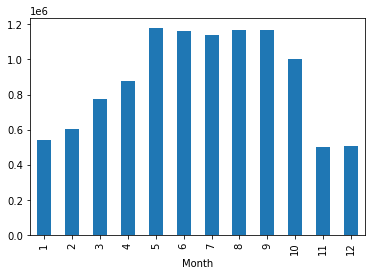

In [100]:
# Visualize possible seasonal effects (monthly, weekly, daily?)
(data.groupby('Month')
 .sum()
 ['Pay_pax']
 .plot.bar())

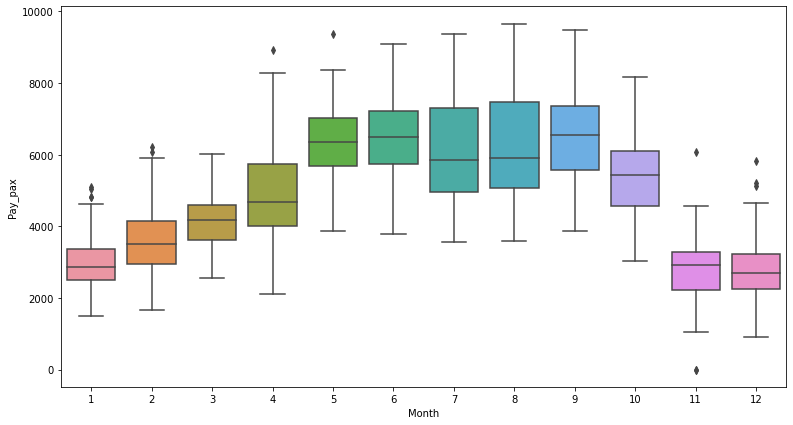

In [101]:
plt.figure(figsize=(13,7))
sns.boxplot(data=data, x="Month", y="Pay_pax", dodge=False)
plt.show()

### Creating holidays variables 

### Visualizating the dataset

1. Autorcorrelation
2. Normality
3. Stationarity

In [102]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y,pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout,(0,0),colspan=2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        qq_ax = plt.subplot2grid(layout,(2,0))
        pp_ax = plt.subplot2grid(layout,(2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Serie Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sma.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        ss.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

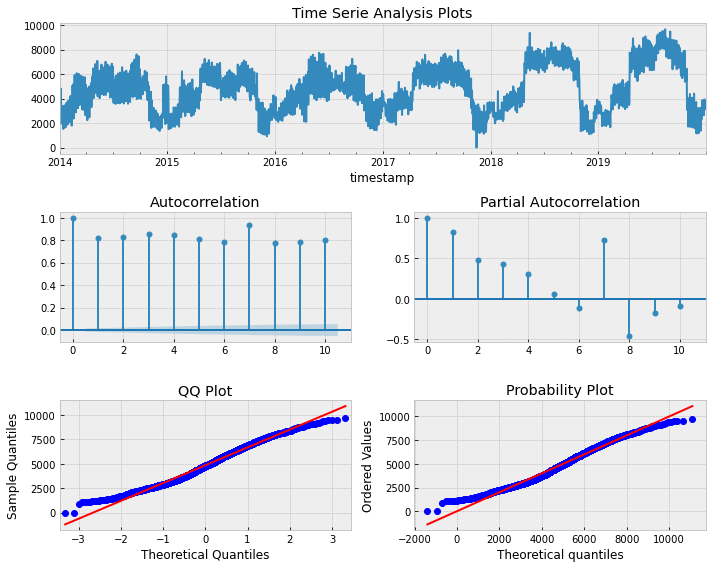

In [103]:
tsplot(data['Pay_pax'], lags=10)

## Creating the training & testing sets + implementing features

In [104]:
#Partition the data into a train and test set
y_to_train = data['2016':'2019-06'] # dataset to train
y_to_val = data['2019-07':] # last X months for test  
predict_date = len(data) - len(data[:'2019-06'])
predict_date

184

In [105]:
y_to_train['Pay_pax_L1'] =y_to_train['Pay_pax'].shift(-1)
y_to_train['Pay_pax_L2'] =y_to_train['Pay_pax'].shift(-2)
y_to_train['Pay_pax_L3'] =y_to_train['Pay_pax'].shift(-3)

y_to_val['Pay_pax_L1'] =y_to_val['Pay_pax'].shift(-1)
y_to_val['Pay_pax_L2'] =y_to_val['Pay_pax'].shift(-2)
y_to_val['Pay_pax_L3'] =y_to_val['Pay_pax'].shift(-3)


<ipython-input-105-97564dd502cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_train['Pay_pax_L1'] =y_to_train['Pay_pax'].shift(-1)
<ipython-input-105-97564dd502cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_train['Pay_pax_L2'] =y_to_train['Pay_pax'].shift(-2)
<ipython-input-105-97564dd502cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

<ipython-input-106-6b896cb68f56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_train['R_Mean_10'] = y_to_train['Pay_pax'].rolling(10).mean()
<ipython-input-106-6b896cb68f56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_train['R_Vol_10'] = y_to_train['Pay_pax'].rolling(10).std()
<ipython-input-106-6b896cb68f56>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<AxesSubplot:xlabel='timestamp'>

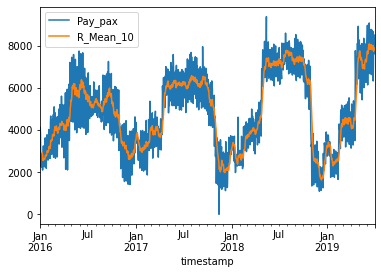

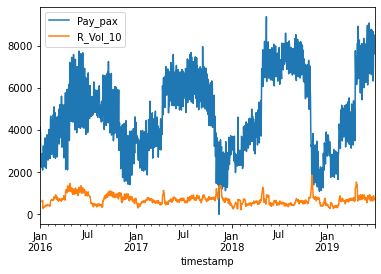

In [106]:
y_to_train['R_Mean_10'] = y_to_train['Pay_pax'].rolling(10).mean()
y_to_train['R_Vol_10'] = y_to_train['Pay_pax'].rolling(10).std()

y_to_val['R_Mean_10'] = y_to_val['Pay_pax'].rolling(10).mean()
y_to_val['R_Vol_10'] = y_to_val['Pay_pax'].rolling(10).std()

y_to_train[['Pay_pax', 'R_Mean_10']].plot()
y_to_train[['Pay_pax', 'R_Vol_10']].plot()

In [107]:
y_to_val

Pay_pax  BookedPayPax  Days_of_year  Month  Week  Week_Month  \
timestamp                                                                  
2019-07-01   8340.0        8502.0           182      7    27           1   
2019-07-02   6316.0        6343.0           183      7    27           1   
2019-07-03   7226.0        7096.0           184      7    27           1   
2019-07-04   7201.0        7186.0           185      7    27           1   
2019-07-05   7976.0        8031.0           186      7    27           1   
...             ...           ...           ...    ...   ...         ...   
2019-12-27   3937.0        3581.0           361     12    52           5   
2019-12-28   3235.0        3215.0           362     12    52           5   
2019-12-29   3810.0        3752.0           363     12    52           5   
2019-12-30   3582.0        3479.0           364     12     1           1   
2019-12-31   3165.0        3469.0           365     12     1           1   

            Day_Number   Day_Name  Time    Time2  Pay_pax_L1  Holidays  \
timestamp                                                                
2019-07-01           1     Monday  2007  4028049      6316.0         0   
2019-07-02           2    Tuesday  2008  4032064      7226.0         0   
2019-07-03           3  Wednesday  2009  4036081      7201.0         0   
2019-07-04           4   Thursday  2010  4040100      7976.0         0   
2019-07-05           5     Friday  2011  4044121      7607.0         0   
...                ...        ...   ...      ...         ...       ...   
2019-12-27          27     Friday  2186  4778596      3235.0         1   
2019-12-28          28   Saturday  2187  4782969      3810.0         1   
2019-12-29          29     Sunday  2188  4787344      3582.0         1   
2019-12-30          30     Monday  2189  4791721      3165.0         1   
2019-12-31          31    Tuesday  2190  4796100         NaN         1   

            Pay_pax_L2  Pay_pax_L3  R_Mean_10    R_Vol_10  
timestamp                                                  
2019-07-01      7226.0      7201.0        NaN         NaN  
2019-07-02      7201.0      7976.0        NaN         NaN  
2019-07-03      7976.0      7607.0        NaN         NaN  
2019-07-04      7607.0      7828.0        NaN         NaN  
2019-07-05      7828.0      8157.0        NaN         NaN  
...                ...         ...        ...         ...  
2019-12-27      3810.0      3582.0     3221.1  423.751617  
2019-12-28      3582.0      3165.0     3259.4  403.509383  
2019-12-29      3165.0         NaN     3353.2  412.374641  
2019-12-30         NaN         NaN     3324.6  381.463032  
2019-12-31         NaN         NaN     3320.3  383.162005  

[184 rows x 16 columns]

In [108]:
#Create dummy variables for each months 
# Comment: dummy variables for days in the week do provide additional predictive power
# Comment: Dummy & radils for periods up and down provide non significant predicitive power

months ={'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6,
         'July':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

for i in list(months.keys()):
    y_to_train[i] = [1 if months[i]==y_to_train['Month'][j] else 0 for j in range(len(y_to_train)) ]
    y_to_val[i] = [1 if months[i]==y_to_train['Month'][j] else 0 for j in range(len(y_to_val)) ]

y_to_val

<ipython-input-108-3fafc7b95efc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_train[i] = [1 if months[i]==y_to_train['Month'][j] else 0 for j in range(len(y_to_train)) ]
<ipython-input-108-3fafc7b95efc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_val[i] = [1 if months[i]==y_to_train['Month'][j] else 0 for j in range(len(y_to_val)) ]


Pay_pax  BookedPayPax  Days_of_year  Month  Week  Week_Month  \
timestamp                                                                  
2019-07-01   8340.0        8502.0           182      7    27           1   
2019-07-02   6316.0        6343.0           183      7    27           1   
2019-07-03   7226.0        7096.0           184      7    27           1   
2019-07-04   7201.0        7186.0           185      7    27           1   
2019-07-05   7976.0        8031.0           186      7    27           1   
...             ...           ...           ...    ...   ...         ...   
2019-12-27   3937.0        3581.0           361     12    52           5   
2019-12-28   3235.0        3215.0           362     12    52           5   
2019-12-29   3810.0        3752.0           363     12    52           5   
2019-12-30   3582.0        3479.0           364     12     1           1   
2019-12-31   3165.0        3469.0           365     12     1           1   

            Day_Number   Day_Name  Time    Time2  ...  Mar  Apr  May  June  \
timestamp                                         ...                        
2019-07-01           1     Monday  2007  4028049  ...    0    0    0     0   
2019-07-02           2    Tuesday  2008  4032064  ...    0    0    0     0   
2019-07-03           3  Wednesday  2009  4036081  ...    0    0    0     0   
2019-07-04           4   Thursday  2010  4040100  ...    0    0    0     0   
2019-07-05           5     Friday  2011  4044121  ...    0    0    0     0   
...                ...        ...   ...      ...  ...  ...  ...  ...   ...   
2019-12-27          27     Friday  2186  4778596  ...    0    0    0     1   
2019-12-28          28   Saturday  2187  4782969  ...    0    0    0     1   
2019-12-29          29     Sunday  2188  4787344  ...    0    0    0     1   
2019-12-30          30     Monday  2189  4791721  ...    0    0    0     0   
2019-12-31          31    Tuesday  2190  4796100  ...    0    0    0     0   

            July  Aug  Sep  Oct  Nov  Dec  
timestamp                                  
2019-07-01     0    0    0    0    0    0  
2019-07-02     0    0    0    0    0    0  
2019-07-03     0    0    0    0    0    0  
2019-07-04     0    0    0    0    0    0  
2019-07-05     0    0    0    0    0    0  
...          ...  ...  ...  ...  ...  ...  
2019-12-27     0    0    0    0    0    0  
2019-12-28     0    0    0    0    0    0  
2019-12-29     0    0    0    0    0    0  
2019-12-30     1    0    0    0    0    0  
2019-12-31     1    0    0    0    0    0  

[184 rows x 28 columns]

In [109]:
# Check is periods up and down match actual variations 
#y_to_train[['Pay_pax', 'Period_up', 'Period_down']].plot()

# 2. Testing Models to predict the sum of passenger (daily)

### Train the model 1: Linear Regression w/ Time and Dummy Variables for Months

In [110]:
my_formula = "Pay_pax ~ Time2 + Holidays +  "+' + '.join(list(months.keys()))
my_formula

'Pay_pax ~ Time2 + Holidays +  Jan + Feb + Mar + Apr + May + June + July + Aug + Sep + Oct + Nov + Dec'

                            OLS Regression Results                            
Dep. Variable:                Pay_pax   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     304.1
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:55:01   Log-Likelihood:                -10507.
No. Observations:                1277   AIC:                         2.104e+04
Df Residuals:                    1263   BIC:                         2.111e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3797.1192     54.737     69.370      0.0

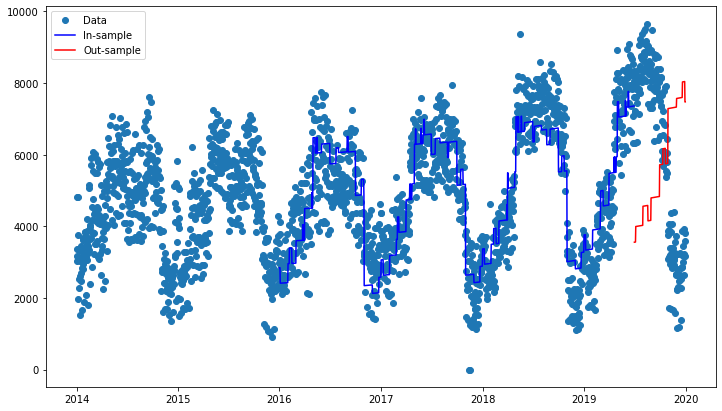

In [111]:
rslt = sm.ols(formula=my_formula, data=y_to_train).fit()
print(rslt.summary())

#insample
ypred = rslt.predict(y_to_train)

#outsample
pred_out = rslt.get_prediction(y_to_val).summary_frame(alpha=0.05)
pred_out = pred_out.set_index(y_to_val.index)
ypred_out_1 = pred_out['mean']
#ypred_UB = pred_out['mean_ci_upper']
#ypred_LB = pred_out['mean_ci_lower']


fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax'], "o", label="Data")
ax.plot(ypred, "b-", label="In-sample")


ax.plot(ypred_out_1, "r-", label="Out-sample")
#ax.plot(ypred_UB, "r--", label="Out-sample UB")
#ax.plot(ypred_LB, "r--", label="Out-sample LB")

mse2 = ((ypred_out_1 - y_to_val['Pay_pax']) ** 2).mean()
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse2), 2)))

ax.legend(loc="best")

### Train model 2: Linear Regression w/ Time and Radial Variables for Months

In [112]:
# radial dummies 
from sklego.preprocessing import RepeatingBasisFunction as RBF
rbf = RBF(n_periods=12,
             column="Days_of_year",
             input_range=(1,365),
             remainder="drop")


In [113]:
rbf.fit(data)
radials = pd.DataFrame(index=data.index,
               	data=rbf.transform(data))
#radials.plot(subplots=True, figsize=(14, 8),
#     	sharex=True, title="Radial Basis Functions",
#     	legend=False);
radials.columns = list(months.keys())
#radials

In [114]:
y_to_train[list(months.keys())] = radials
y_to_val[list(months.keys())] = radials

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


                            OLS Regression Results                            
Dep. Variable:                Pay_pax   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     325.1
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:55:05   Log-Likelihood:                -10437.
No. Observations:                1277   AIC:                         2.090e+04
Df Residuals:                    1262   BIC:                         2.098e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.385e+05   3.33e+05     -0.716      0.4

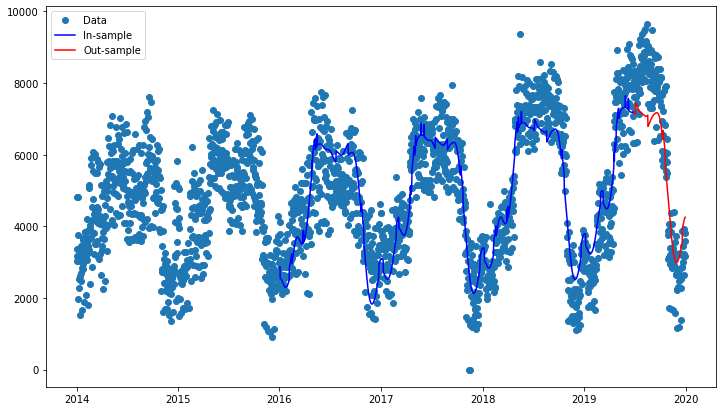

In [115]:
rslt = sm.ols(formula=my_formula, data=y_to_train).fit()
ypred = rslt.predict(y_to_train)
ypred_out_2 = rslt.predict(y_to_val)
print(rslt.summary())


fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax'], "o", label="Data")
ax.plot(ypred, "b-", label="In-sample")
ax.plot(ypred_out_2, "r-", label="Out-sample")
ax.legend(loc="best")

mse2 = ((ypred_out_2 - y_to_val['Pay_pax']) ** 2).mean()
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse2), 2)))
    

### Train model 3: WLS Regression w/ Time and Radial Variables for Months

In [116]:
# Get exponential importance 

x = [int(i) for i in range(1, len(data))]
y = [int(i) for i in range(1, len(data))]
p = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))

# Convert the polynomial back into an exponential
a = np.exp(p[1])
b = p[0]
x_w = np.linspace(np.min(x), np.max(x), len(data))
y_w = a * np.exp(b * x_w)

The Root Mean Squared Error of our forecast is 1044.7


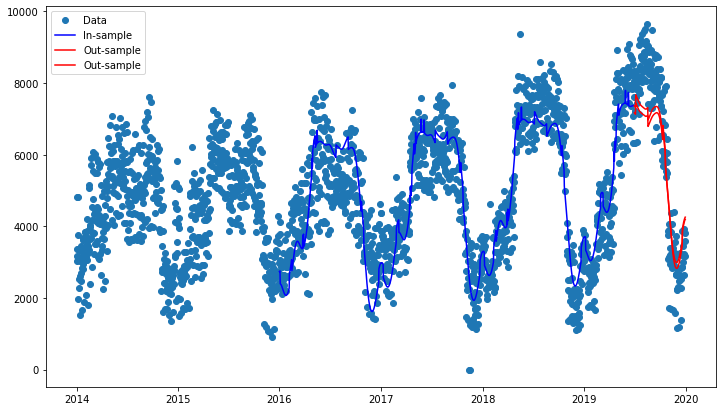

In [117]:
rslt_10 = sm.wls(formula=my_formula, data=y_to_train, weights=y_w[:len(y_to_train)]).fit()
ypred = rslt_10.predict(y_to_train)
ypred_out_10 = rslt_10.predict(y_to_val)


fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax'], "o", label="Data")
ax.plot(ypred, "b-", label="In-sample")
ax.plot(ypred_out_10, "r-", label="Out-sample")
ax.plot(ypred_out_2, "r-", label="Out-sample")
ax.legend(loc="best")

mse2 = ((ypred_out_10 - y_to_val['Pay_pax']) ** 2).mean()
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse2), 2)))

## Testing the Holt-Winter method (additive)

In [118]:
#Set up a function for Holt-Winter's Seasonal Method
def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):

    if seasonal_type == 'additive':
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        fcast2_insample = fcast2[:'2017']
        fcast2_outsample = fcast2['2018':]
        mse2 = ((fcast2_outsample - y_to_test['2018':]) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fig, ax = plt.subplots(figsize=(12,7))
        ax.plot(y, "o", label="Data")
        ax.plot(fit2.fittedvalues, "b-", label="In-sample")
        ax.plot(fcast2_outsample, "r-", label="Out-sample")
        ax.legend(loc="best")
    
    
    
    elif seasonal_type == 'multiplicative':  
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='mul', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        fcast4_insample = fcast4[:'2017']
        fcast4_outsample = fcast4['2018':]
        mse4 = ((fcast4['2018':] - y_to_test['2018':]) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fig, ax = plt.subplots(figsize=(12,7))
        ax.plot(y, "o", label="Data")
        ax.plot(fit4.fittedvalues, "b-", label="In-sample")
        ax.plot(fcast4_outsample, "r-", label="Out-sample")
        ax.legend(loc="best")
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

<ipython-input-118-f9e3e460c961>:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(


The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=365 and a Box-Cox transformation 1365.88


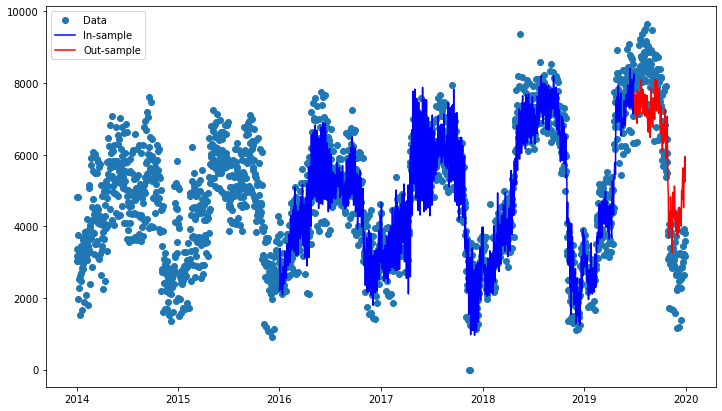

In [119]:
holt_win_sea(data['Pay_pax'], y_to_train['Pay_pax'],y_to_val['Pay_pax'],'additive',365, 184) #Call the function


<ipython-input-118-f9e3e460c961>:22: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='mul', seasonal='add', damped=True).fit(use_boxcox=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=365 and a Box-Cox transformation 1769.51


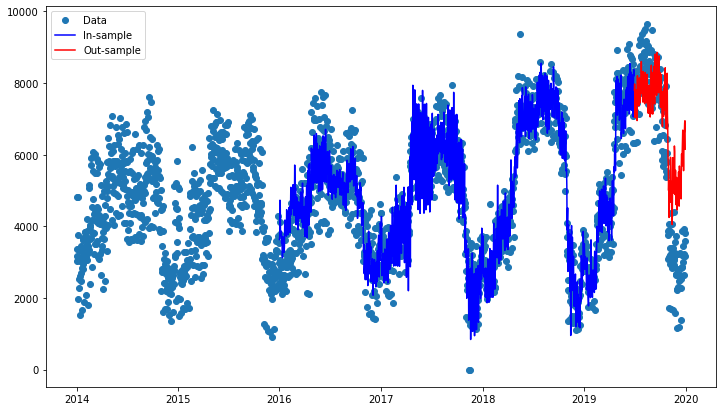

In [120]:
holt_win_sea(data['Pay_pax'], y_to_train['Pay_pax'],y_to_val['Pay_pax'],'multiplicative',365, 184) #Call the function

# incorporating volatility and average returns 

In [121]:
y_to_train['R_Mean_10'] = y_to_train['Pay_pax'].rolling(10).mean()
y_to_train['R_Vol_10'] = y_to_train['Pay_pax'].rolling(10).std()
y_to_train['R_Vol_50'] = y_to_train['Pay_pax'].rolling(50).std()

y_to_val['R_Mean_10'] = data['Pay_pax'].rolling(10).mean()['2019-07':]
y_to_val['R_Vol_10'] = data['Pay_pax'].rolling(10).std()['2019-07':]
y_to_val['R_Vol_50'] = data['Pay_pax'].rolling(50).std()['2019-07':]


<ipython-input-121-fc8ddc25b631>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_train['R_Mean_10'] = y_to_train['Pay_pax'].rolling(10).mean()
<ipython-input-121-fc8ddc25b631>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_train['R_Vol_10'] = y_to_train['Pay_pax'].rolling(10).std()
<ipython-input-121-fc8ddc25b631>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [134]:
my_formula = "Pay_pax ~ R_Mean_10 + R_Vol_50 + Holidays +"+' + '.join(list(months.keys()))
my_formula

'Pay_pax ~ R_Mean_10 + R_Vol_50 + Holidays +Jan + Feb + Mar + Apr + May + June + July + Aug + Sep + Oct + Nov + Dec'

                            OLS Regression Results                            
Dep. Variable:                Pay_pax   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     491.2
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:55:49   Log-Likelihood:                -9769.8
No. Observations:                1228   AIC:                         1.957e+04
Df Residuals:                    1212   BIC:                         1.965e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.469e+05   2.76e+05      2.345      0.0

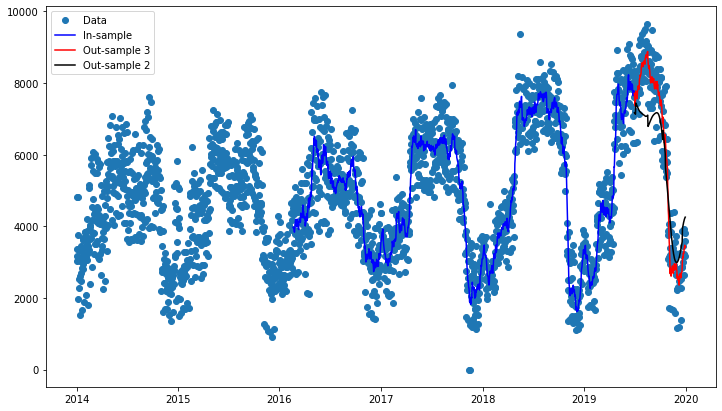

In [135]:
rslt = sm.ols(formula=my_formula, data=y_to_train).fit()
ypred = rslt.predict(y_to_train)
ypred_out_3 = rslt.predict(y_to_val)
print(rslt.summary())


fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax'], "o", label="Data")
ax.plot(ypred, "b-", label="In-sample")
ax.plot(ypred_out_3, "r-", label="Out-sample 3")
ax.plot(ypred_out_2, "black", label="Out-sample 2")
ax.legend(loc="best")

mse2 = ((ypred_out_3 - y_to_val['Pay_pax']) ** 2).mean()
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse2), 2)))

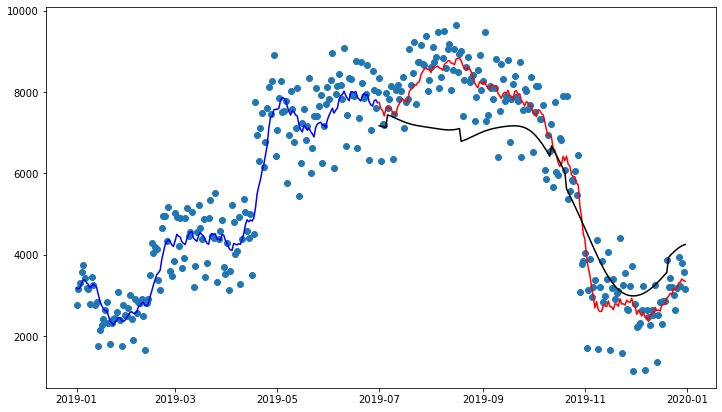

In [124]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax']['2019':], "o", label="Data")
ax.plot(ypred['2019':], "b-", label="In-sample")
ax.plot(ypred_out_3, "r-", label="Out-sample 3")
ax.plot(ypred_out_2, "black", label="Out-sample 2")
plt.show()

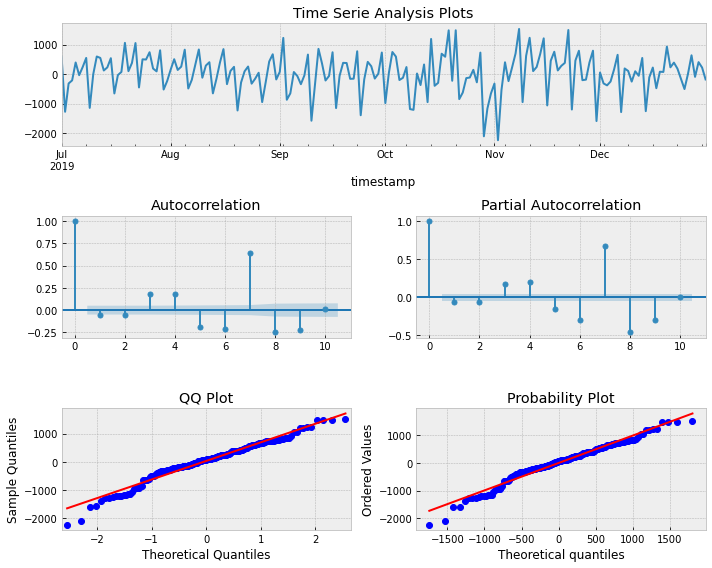

In [125]:
err3 = (data['Pay_pax']['2019-07':] - ypred_out_3)
tsplot(err3, lags=10)

# Incorporating weekly pattern 

In [126]:
y_to_train['L_7'] = y_to_train['Pay_pax'].shift(-7)
y_to_val['L_7'] = data['Pay_pax'].shift(-7)['2019-07':]

<ipython-input-126-960820bb2cc8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_train['L_7'] = y_to_train['Pay_pax'].shift(-7)
<ipython-input-126-960820bb2cc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_to_val['L_7'] = data['Pay_pax'].shift(-7)['2019-07':]


In [127]:
my_formula = "Pay_pax ~ L_7 + R_Mean_10 + R_Vol_50 +"+' + '.join(list(months.keys()))
my_formula

'Pay_pax ~ L_7 + R_Mean_10 + R_Vol_50 +Jan + Feb + Mar + Apr + May + June + July + Aug + Sep + Oct + Nov + Dec'

                            OLS Regression Results                            
Dep. Variable:                Pay_pax   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     1073.
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:55:31   Log-Likelihood:                -9277.1
No. Observations:                1221   AIC:                         1.859e+04
Df Residuals:                    1205   BIC:                         1.867e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.053e+05   1.93e+05     -3.128      0.0

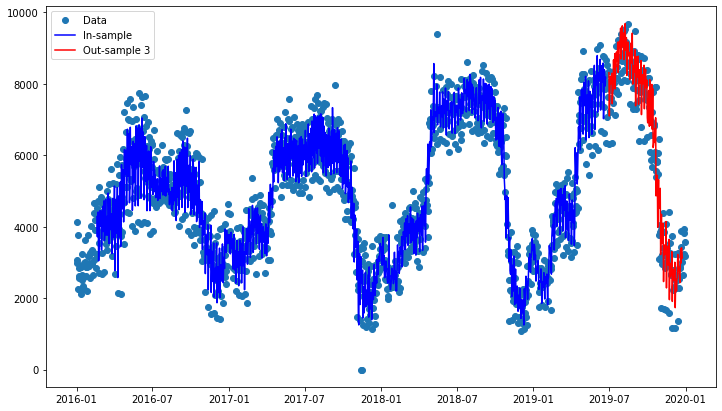

In [128]:
rslt = sm.ols(formula=my_formula, data=y_to_train).fit()
ypred = rslt.predict(y_to_train)
ypred_out_4 = rslt.predict(y_to_val)
print(rslt.summary())


fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax']['2016':], "o", label="Data")
ax.plot(ypred, "b-", label="In-sample")
ax.plot(ypred_out_4, "r-", label="Out-sample 3")
ax.legend(loc="best")

mse2 = ((ypred_out_4 - y_to_val['Pay_pax']) ** 2).mean()
print('The Root Mean Squared Error of our forecast is {}'.format(round(np.sqrt(mse2), 2)))

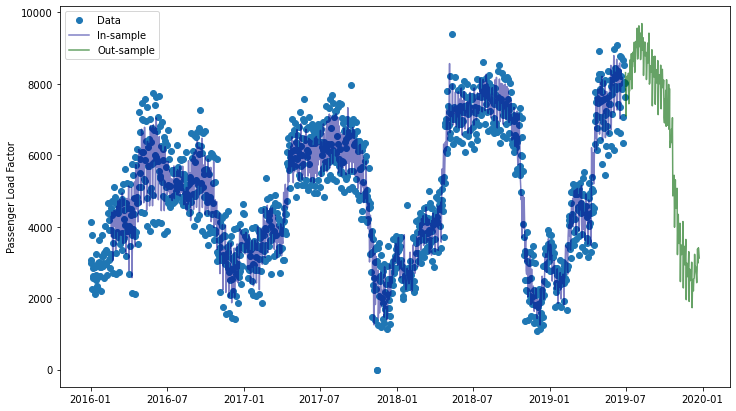

In [129]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax']['2016':'2019-06'], "o", label="Data")
ax.plot(ypred, color='darkblue', label="In-sample", alpha=0.5)
ax.plot(ypred_out_4, color='darkgreen', label="Out-sample", alpha=0.6)
ax.legend(loc="best")
plt.ylabel('Passenger Load Factor')
plt.show()

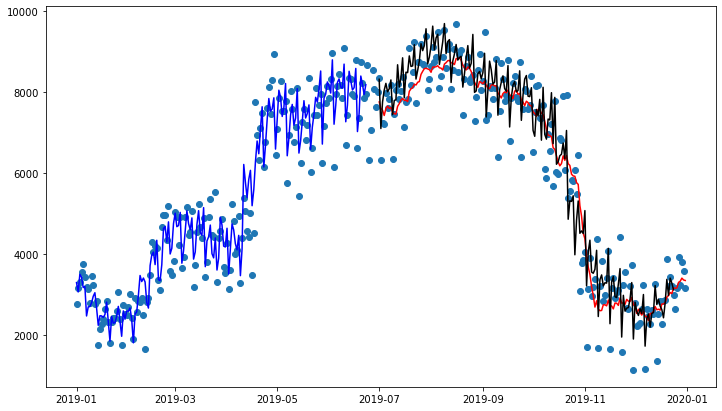

In [130]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(data['Pay_pax']['2019':], "o", label="Data")
ax.plot(ypred['2019':], "b-", label="In-sample")
ax.plot(ypred_out_3, "r-", label="Out-sample 3")
ax.plot(ypred_out_4, "black", label="Out-sample 4")
plt.show()

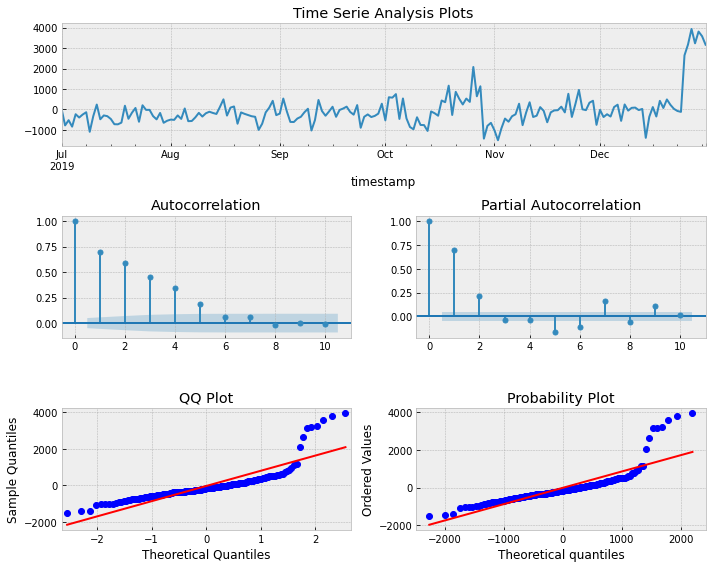

In [131]:
ypred_out_4 = ypred_out_4.fillna(0)
err4 = (data['Pay_pax']['2019-07':] - ypred_out_4)
tsplot(err4, lags=10)